In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import xarray as xr
import pandas as pd

from glob import glob


import os
from netCDF4 import Dataset as netcdf_dataset



In [2]:
#import data and create dictionary
# create a dictionary with the datasets
file_list = glob('/work/m1c/CMIP6_biome_PSS_data/*.nc')

file_list_biovol = glob('/work/m1c/CMIP6_biome_PSS_data/*biovolume.nc')
file_list_biovol_zoo_only = [x for x in file_list_biovol if 'zoo-only' in x]
file_list_biovol_phyto_only = [x for x in file_list_biovol if 'phyto-only' in x]
file_list_biovol = list(set(file_list_biovol).difference(file_list_biovol_zoo_only+file_list_biovol_phyto_only))

file_list_climatology = glob('/work/m1c/CMIP6_biome_PSS_data/*climatology_all*')

file_list_gCarbon = list(set(file_list).difference(file_list_biovol+file_list_climatology))

In [3]:
file_list_biovol

['/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_IPSL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_UKESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CMCC_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GISS_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CESM_PSS_ssp5_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_GFDL_PSS_hist_biovolume.nc',
 '/work/m1c/CMIP6_biome_PSS_data/biom_CNRM_PSS_ssp5_biovolume.nc']

In [4]:
#open the files, and modify time labels to months
model_list =['CESM','CMCC','CNRM','GFDL','GISS', 'IPSL','UKESM'] #['CESM', 'CMCC','CNRM','GFDL', 'GISS','IPSL','UKESM']
ds_dict = {}
ds_dict['hist']={}
ds_dict['ssp5']={}

for e in ['hist', 'ssp5']:
    for m in model_list:
        model_path = [x for x in file_list_biovol if e in x and m in x]
        ds_dict[e][m]= xr.open_mfdataset(model_path).groupby('time.month').mean(dim='time')
        if e == 'hist':
            vars = [ 'betas_hist', 'intercept_hist', 'R2_hist', 'RMSE_hist', 'total_biovolume_hist']
        elif e == 'ssp5':
            vars = [ 'betas_ssp5', 'intercept_ssp5', 'R2_ssp5', 'RMSE_ssp5', 'total_biovolume_ssp5']
            
        for var in vars: # biomass arrays here
            SH_subset = ds_dict[e][m][var].where(ds_dict[e][m][var].lat < 0,drop=True).values # selecting southern hemisphere
            SH_subset = np.roll(SH_subset, shift=6, axis=0) #shift the season occurence by six months (only southern hemispher)
            full_field = ds_dict[e][m][var].values #select biomass values for each of the phytoplankton groups
            full_field[:,0:np.size(SH_subset, axis=1),:] = SH_subset # from full_field biomass subset, select all months (1st dim), 
            #latitudes from 0 to the lenght of southen hemisphere subset (dim2) and all longitudes
            svar = var #+ '_shift' # 
            ds_dict[e][m][svar] = xr.DataArray(full_field, dims=ds_dict[e][m][var].dims, coords=ds_dict[e][m][var].coords)

In [5]:
ds_dict['hist']['CMCC']

<xarray.Dataset>
Dimensions:               (month: 12, lat: 180, lon: 360, biovol_um3: 50)
Coordinates:
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * biovol_um3            (biovol_um3) float64 5.939 10.66 ... 1.697e+13
  * month                 (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/19)
    biomes                (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    chl                   (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    NB                    (month, biovol_um3, lat, lon) float64 dask.array<chunksize=(1, 50, 180, 360), meta=np.ndarray>
    total_biovolume_hist  (month, lat, lon) float64 nan nan ... 8.642e+12
    betas_hist            (month, lat, lon) float64 nan nan ... -1.076 -1.076
    intercept_hist        (month, lat, lon) float64 nan nan ... 1.805e+12
    ...                    ...
    phymisc_per           (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    phydiat_per           (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zmicro_per            (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zmeso_per             (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    phyc                  (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zooc                  (month, lat, lon) float64 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

In [6]:
def assign_seasons(month):
    if month in ['12.0', '1.0', '2.0']:
        return 'Winter'
    elif month in ['3.0', '4.0', '5.0']:
        return 'Spring'
    elif month in ['6.0', '7.0', '8.0']:
        return 'Summer'
    elif month in ['9.0', '10.0', '11.0']:
        return 'Fall'
    
# open files, average by 'select', and save again.
def average_Taylor_files(df):
    #print(df.head())
    df =df.astype(dict(zip(['month'],[str]))).groupby(['source','month', 'experiment', 'biomes']).apply(lambda x: pd.Series({

                                                                    'slope':np.nanmean(x.slope),
                                                                    'intercept':np.nanmean(x.intercept),
                                                                    'R2':np.nanmean(x.R2),
                                                                    'total_biovolume':np.nanmean(x.total_biovolume),})).reset_index()
    return df    

In [7]:
all_df = pd.DataFrame()
for e in ['hist', 'ssp5']:
    for m in model_list:
        test_df = ds_dict[e][m].to_dataframe()
        test_df=test_df.dropna().reset_index()
        test_df=test_df.drop_duplicates().reset_index(drop=True)
        if e == 'hist':
            vars = [ 'betas_hist', 'intercept_hist', 'R2_hist','total_biovolume_hist']
        elif e == 'ssp5':
            vars = [ 'betas_ssp5', 'intercept_ssp5', 'R2_ssp5', 'total_biovolume_ssp5']
        test_df = test_df[['lat', 'lon', 'month', 'biomes']+vars]
        if e == 'hist':
            test_df.rename(columns={'betas_hist':'slope', 'intercept_hist':'intercept', 'R2_hist':'R2', 'total_biovolume_hist':'total_biovolume'}, inplace=True)
            test_df['experiment'] = 'hist'
        elif e == 'ssp5':
            test_df.rename(columns={'betas_ssp5':'slope', 'intercept_ssp5':'intercept', 'R2_ssp5':'R2', 'total_biovolume_ssp5':'total_biovolume'}, inplace=True)
            test_df['experiment'] = 'ssp5'
        test_df['source'] = m
        test_df['month'] = test_df['month'].astype(str)+'.0'#.str.zfill(2)
        test_df['season'] = test_df['month'].apply(assign_seasons)
        test_df['biomes'] = test_df['biomes'].astype(str)
        test_df = test_df.replace({'biomes':{'1.0':'LC','2.0':'HCSS','3.0':'HCPS'}})
        all_df= pd.concat([all_df, test_df])
all_df=all_df.drop_duplicates().reset_index(drop=True)     
all_df

,lat,lon,month,biomes,slope,intercept,R2,total_biovolume,experiment,source,season
0,-77.5,-179.5,1.0,HCSS,-0.907265,1.448721e+11,0.976717,3.604478e+12,hist,CESM,Winter
1,-77.5,-178.5,1.0,HCSS,-0.909153,1.584194e+11,0.976510,3.791176e+12,hist,CESM,Winter
2,-77.5,-177.5,1.0,HCSS,-0.911068,1.739923e+11,0.976300,3.999223e+12,hist,CESM,Winter
3,-77.5,-176.5,1.0,HCSS,-0.912826,1.916664e+11,0.976097,4.241474e+12,hist,CESM,Winter
4,-77.5,-175.5,1.0,HCSS,-0.914441,2.114271e+11,0.975898,4.516142e+12,hist,CESM,Winter
...,...,...,...,...,...,...,...,...,...,...,...
4385478,77.5,177.5,12.0,HCSS,-1.151904,7.503153e+12,0.985942,3.081296e+12,ssp5,UKESM,Winter
4385479,77.5,178.5,12.0,HCSS,-1.152228,7.533209e+12,0.985924,3.073716e+12,ssp5,UKESM,Winter
4385480,77.5,179.5,12.0,HCSS,-1.152508,7.562250e+12,0.985905,3.068633e+12,ssp5,UKESM,Winter
4385481,78.5,-165.5,12.0,HCSS,-1.152636,7.479914e+12,0.985736,2.990052e+12,ssp5,UKESM,Winter


In [8]:
all_df.to_csv('/work/m1c/CMIP6_biome_PSS_data/CMIP6_data_full_biovolume.csv', sep= ',', index = False)

In [9]:
df_CMIP6= average_Taylor_files(all_df)
#print (len(subset))
#subset.head()
df_CMIP6.to_csv('/work/m1c/CMIP6_biome_PSS_data/CMIP6_data_Taylor.csv', sep= ',', index = False)
df_CMIP6

,source,month,experiment,biomes,slope,intercept,R2,total_biovolume
0,CESM,1.0,hist,HCPS,-1.045892,2.259949e+13,0.969896,3.475176e+13
1,CESM,1.0,hist,HCSS,-1.025019,9.916039e+12,0.966497,1.523927e+13
2,CESM,1.0,hist,LC,-1.080000,2.328007e+13,0.992063,2.921115e+13
3,CESM,1.0,ssp5,HCPS,-1.031602,2.067967e+13,0.960408,3.233847e+13
4,CESM,1.0,ssp5,HCSS,-0.977476,6.231281e+12,0.946044,1.158774e+13
...,...,...,...,...,...,...,...,...
499,UKESM,9.0,hist,HCSS,-1.153157,1.402819e+14,0.983427,6.124621e+13
500,UKESM,9.0,hist,LC,-1.274975,1.908405e+14,0.989319,1.623718e+13
501,UKESM,9.0,ssp5,HCPS,-1.170869,1.621267e+14,0.986461,5.747363e+13
502,UKESM,9.0,ssp5,HCSS,-1.168663,1.454944e+14,0.984597,5.444108e+13


In [10]:
palette_source = dict(CESM= 'red',CMCC= 'cyan', CNRM= 'gray',GFDL= 'lawngreen', GISS= 'orange', IPSL= 'gold',UKESM= 'purple', PSSdb = 'blue')
palette_experiments= dict(hist='rosybrown', ssp5='firebrick', obs='blue')
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.' ,'u.']

In [11]:
from matplotlib.legend import Legend
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as tick
def y_fmt(x, y):
    return '${:1.0e}'.format(x).replace('e', '\\times 10^{') + '}$'

In [12]:
df_CMIP6['intercept_trans'] = np.log10(df_CMIP6['intercept'])

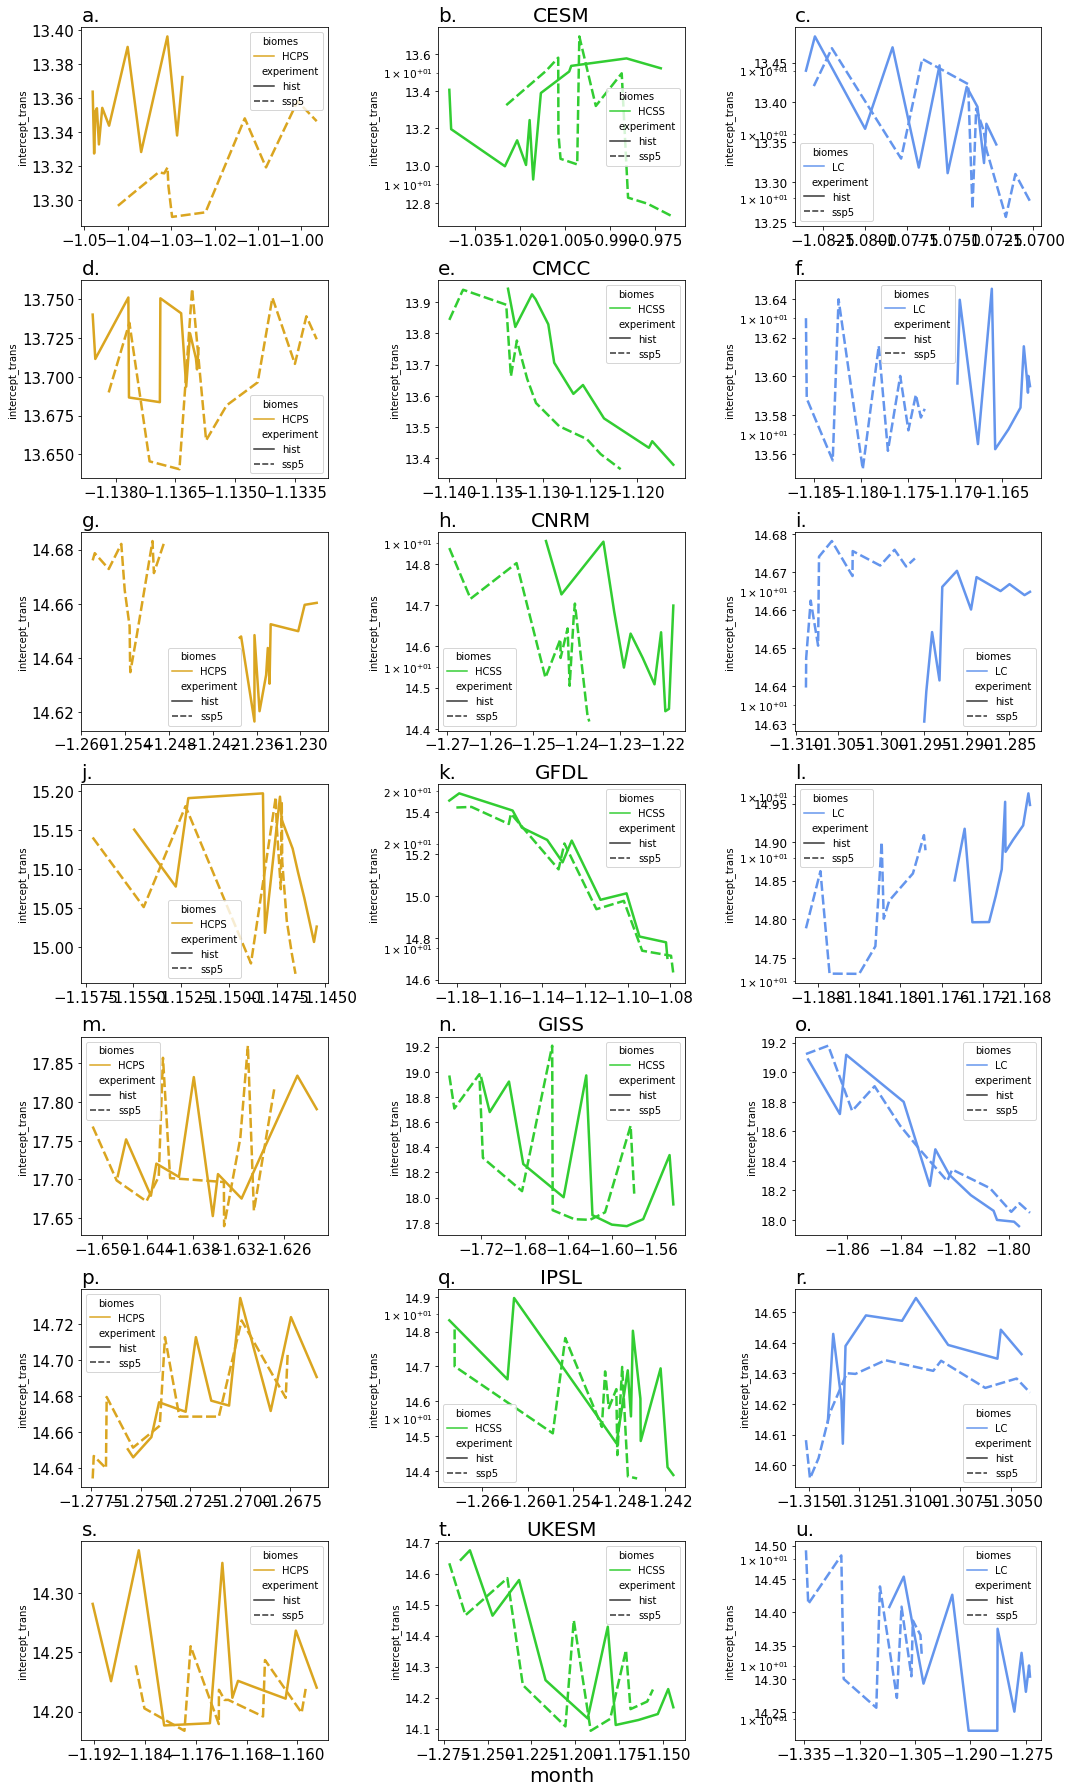

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
model_list = ['CESM', 'CMCC', 'CNRM', 'GFDL', 'GISS', 'IPSL', 'UKESM']

palette = dict(LC= 'cornflowerblue', HCSS= 'limegreen', HCPS= 'goldenrod')
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,25))
variables = ['slope', 'intercept', 'total_biovolume']
ind=0
for r, m in enumerate(model_list):
    #print(r)
    for c, var in enumerate(df_CMIP6.biomes.unique()):
        #print(c)
        ind +=1
        ax_n = axs[r,c]
        clim=sns.lineplot(ax = ax_n,x = 'slope', y='intercept_trans',hue = 'biomes',palette=palette, style = 'experiment', style_order=['hist','ssp5'],linewidth = 2.5, data=df_CMIP6[(df_CMIP6 ['source']== m) & (df_CMIP6 ['biomes']== var)] ).set(title= (var + ' for model ' + m + ' by biome'))
        ax_n.tick_params(axis='both', which='major', labelsize=15)
        ax_n.set_title(letters[ind-1], loc='left', fontsize=20)
        #ax_n.set_yscale('log')
        #ax_n.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if c == 1:
            ax_n.set_title(m, fontsize=20)
        else:
            ax_n.set_title('')
        if r ==6 and c ==1:
            ax_n.set_xlabel('month', fontsize=20)
        else:
            ax_n.set_xlabel('', fontsize=20)

        #if r ==0 and c ==2:
            #L=ax_n.legend()
            #L.get_texts()[5].set_text('historical period \n (1985-2014)')
            #L = ax_n.legend(title='', fontsize = 'x-large',  markerscale=10, frameon=False, bbox_to_anchor=(1, 1))
            #L.get_texts()[0].set_text('')
            #L.get_texts()[4].set_text('')
            #L.get_texts()[5].set_text('historical period \n (1985-2014)')
            #L.get_texts()[6].set_text('SSP5-8.5 \n (2070-2100)')
            #for line in L.get_lines():
                #line.set_linewidth(4.0)
        #else:
            #ax_n.get_legend().remove()
        
        if c==1 or c==2:
            #ax_n.ticklabel_format(axis='y', style='scientific')
            #ax_n.set_yscale('log')
            ax_n.get_yaxis().set_minor_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
            ax_n.yaxis.set_minor_formatter(tick.FuncFormatter(y_fmt))
            #ax_n.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax_n.yaxis.set_minor_locator(plt.MaxNLocator(4))
            ax_n.tick_params(axis='y', which='major', labelsize=12)
            ax_n.tick_params(axis='y', which='minor', labelsize=10.5)# rotation=90

        ax_n.xaxis.set_major_locator(plt.MaxNLocator(6))
        #ax_n.set_xticklabels([2,4,6,8,10,12], fontsize=15)


        
            
plt.tight_layout()
plt.savefig('/work/m1c/CMIP6_size_spectra_scripts/plots/fig_biomes_slope_intercept_test.pdf', dpi=300)

In [14]:
df_pssdb = pd.read_csv('/work/m1c/CMIP6_biome_PSS_data/PSSdb_data_full.csv', sep= ',')
df_pssdb= average_Taylor_files(df_pssdb)
df_pssdb.to_csv('/work/m1c/CMIP6_biome_PSS_data/PSSdb_data_Taylor.csv', sep= ',', index = False)
df_pssdb


,source,month,experiment,biomes,slope,intercept,R2,total_biovolume
0,PSSdb,1.0,obs,HCPS,-1.172460,14.498022,0.969100,1.801459e+11
1,PSSdb,1.0,obs,HCSS,-1.140567,13.422308,0.970419,7.664530e+10
2,PSSdb,1.0,obs,LC,-1.240634,15.055293,0.974591,7.332700e+10
3,PSSdb,10.0,obs,HCPS,-1.035474,13.367275,0.966691,6.309314e+11
4,PSSdb,10.0,obs,HCSS,-1.042738,13.379455,0.959511,1.208623e+12
5,PSSdb,10.0,obs,LC,-1.283963,15.040926,0.950606,2.004759e+11
6,PSSdb,11.0,obs,HCPS,-0.987498,13.031738,0.973445,1.554797e+11
7,PSSdb,11.0,obs,HCSS,-1.217861,14.287757,0.961038,8.847887e+10
8,PSSdb,11.0,obs,LC,-1.283204,15.150443,0.959167,4.658737e+10
9,PSSdb,12.0,obs,HCPS,-1.058685,13.640567,0.963506,9.682829e+11
